# 2 Automatic Modulation Classification: Deep Learning Baseline

In this notebook we will go over some PyTorch basics and build a neural network to classify the same data we had for the ML baseline.

## Dependencies

NumPy and Matplotlib are still our everlasting friends, additionally we import PyTorch and some useful modules like nn for neural network layers and optim for optimizers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from ml_helpers import *
from comms_helpers import *

## Data

The training data consists of the 5 modulation classes, each consisting of 128 samples per frame. The difference between the classical ML approach with the decision trees and a DL approach with neural networks is that we do not calculate or engineer features anymore - our raw IQ samples are gonna go straight into the Deep Neural Network (DNN) and through layers of abstraction our model will learn relevant features on its own.

In terms of data preparation we will concatenate frames of raw samples instead of vectors. Additionally now that we are working with PyTorch, we want our data to be converted to torch tensors rather than numpy arrays (this is pretty straightforward and done in the function below).

Since our first layers in the model are going to be convolutional layers (nn.conv2d), the required input tensor shape is (N,C,H,W), where N is the number of frames (or batch size), C is the number of channels (if we were dealing with images this would be RGB), H is the height of our data and W is the width. Complex neural networks aren't quite there yet in mainstream deep learning libraries such as PyTorch, so what people in the wireless communications domain often do is separate the I/Q samples into 2 different channels - in our case we will treat the I/Q channel dimension as the height and the samples as the width.

More concretely, 32x128 (32 frames of 128 complex samples) becomes -> 32x1x2x128 (32 tensors with 2 channels for I/Q, and 128 samples per channel).

In [2]:
def gen_tensor_data(mod_scheme, num_frames=32, samples_per_frame=128, sps=5, snr=30):
            
    symbols_required = int(np.ceil(samples_per_frame/sps))*num_frames
        
    # Mod scheme has to be one of: 'BPSK', 'QPSK', '16-QAM'
    if mod_scheme == 'BPSK':
        symbols = pulse_shape(generate_bpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == 'QPSK':
        symbols = pulse_shape(generate_qpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '8-PSK':
        symbols = pulse_shape(generate_psk8(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '16-QAM':
        symbols = pulse_shape(generate_qam(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '4-ASK':
        symbols = pulse_shape(generate_ask4(symbols_required), sps=sps)[:num_frames*samples_per_frame]

    # Add noise and split into frames
    frames = awgn(symbols.reshape(num_frames,-1), snr)

    # Normalize to unit energy per frame
    for i, frame in enumerate(frames):
        power = np.mean((np.abs(frame)))
        frames[i] = frame / power

    # Split into I/Q, add extra channel to make a 4-D tensor
    return torch.FloatTensor(np.stack((frames.real, frames.imag),axis=1))

def gen_data_from_list(mod_scheme, snr_range, num_frames=32, samples_per_frame=128):
    
    # total dataset size
    frames = torch.zeros((num_frames*len(snr_range), 2, samples_per_frame), dtype=torch.float)
    
    # snrs dataset for multitask
    snrs = torch.zeros(num_frames*len(snr_range), dtype=torch.float)
    
    for i, snr in enumerate(snr_range):
        frames[i*num_frames:(i+1)*num_frames] = gen_tensor_data(mod_scheme, num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
        snrs[i*num_frames:(i+1)*num_frames] = snr
    
    return frames, snrs

In [3]:
# Function returns a torch dataloader with specified batch_size and num_frames
# number of examples per snr level
def gen_loader(num_frames=32, samples_per_frame=1024, snr=[30], batch_size=32):
    
    # Generate the individual waveforms for each modulation scheme
    bpsk_data, bpsk_snrs = gen_data_from_list('BPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    qpsk_data, qpsk_snrs = gen_data_from_list('QPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    psk_data, psk_snrs = gen_data_from_list('8-PSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    qam_data, qam_snrs = gen_data_from_list('16-QAM', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    ask_data, ask_snrs = gen_data_from_list('4-ASK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    
    # Concat them into a single training data tensor
    train_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))
    
    # Create class labels
    bpsk_labels = torch.zeros(bpsk_data.shape[0])
    qpsk_labels = torch.ones(qpsk_data.shape[0])
    psk_labels = torch.ones(psk_data.shape[0])*2
    qam_labels = torch.ones(qam_data.shape[0])*3
    ask_labels = torch.ones(ask_data.shape[0])*4

    # Concat class labels
    # We will be using cross entropy loss, which expects a long tensor as the label hence the .long() here
    train_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels)).long()
    
    # SNR labels
    train_labels_snr = 1/10**(torch.cat((bpsk_snrs, qpsk_snrs, psk_snrs, qam_snrs, ask_snrs))/10) # linear noise as labels
    
    # if gpu
    train_data = train_data.cuda()
    train_labels = train_labels.cuda()
    train_labels_snr = train_labels_snr.cuda()
    
    # Create a Torch dataset
    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels, train_labels_snr)
    
    return torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

We can generate a test dataloader and see how it behaves. We generate 128 frames per SNR per modulation scheme, so we expect to have 128x3x5=1920 examples.

In [4]:
data_loader = gen_loader(num_frames=128, snr=[10,15,20], batch_size=32)
print(len(data_loader))

60


However length is 60... What's wrong? Well torch dataloaders are iterables, and we gave ours a batch_size of 32, meaning each iteration we expect 32 frames to pop out. So if we multiply our result by the batch size

In [5]:
len(data_loader)*32

1920

Presto! Exactly what we expected. Now onto the model building.

## Model

Each PyTorch model is defined as its own class which inherits all of its functionality from the base nn.Module. Typically you only need to flesh out its 2 functions:
* **\_\_init__** - where we will define all the layers we'll want to use in the model - you can even pass arguments to the constructor and make these conditional!
* **forward** - the forward pass function, that actually applies all these layers to our input. If you are familiar with backpropagation, yes this is that forward pass, however the PyTorch autograd capabilities take care of all the training details for us, so we don't really have to worrry about any gradients or backward passes.

We will be using a relatively small network with 3 convolutional layers and 2 fully connected layers with the final output being 5 neurons wide for our 5 classes.

In [6]:
class amc_model(nn.Module):
    def __init__(self):
        super(amc_model, self).__init__()
            
        # 3 conv layers with a 9 sample wide kernel and padding so that the
        # size of the output remains consistent with the input for each layer
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        # 128 samples x 16 output filters x 2 channels (I/Q) = 4096
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        
        # Extract features with convolutional layers
        x = self.convolutions(x)
        
        # Flatten so it's compatible with fully connected layers for classification
        x = torch.flatten(x,1)
#         print(x.shape)
        
#         First fully connected layer
        x = F.selu(self.fc1(x))
        
        # Final layer responsible for classifying the 5 modulation schemes
        x = F.selu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x

We can instantiate our model like we do any other object in Python. Additionally PyTorch gives us a handy summary of what we have going.

In [7]:
model = amc_model()
model

amc_model(
  (convolutions): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): MaxPool1d(kernel_size=2, strid

## Training loop

Most PyTorch training loops will look very similar to this. Main things we are doing here for every loop are:
* Zero out / clear the optimizer gradients
* Use model to predict the training dataset classes
* Evaluate predictions using a loss function (categorical cross-entropy in our case, very popular for classification)
* Do a backwards pass (backpropagation) from the error
* Update model weights based on the gradients (optimizer does all this for us)

Additional validation steps
* Use model to predict validation dataset classes
* Compare the result with the previous best, and if this is better save this model state

The function will return the model state dictionary, containing all the saved weights, of the model that performed best on the validation dataset.

In [8]:
# Function that incorporates the entire training loop of our model, trains model
# for num_epochs number of epochs, validates after each epoch, saves and returns
# only the best performing model on the validation set
def train_model(model, optimizer, train_loader, val_loader, num_epochs=5, verbose=True):

    # Pre-allocate empty lists for losses storage
    losses, val_losses = [], []
    
    # Define our evaluation criterion
    loss_fn = nn.CrossEntropyLoss()#nn.MSELoss()

    # Main training loop
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0

        best_loss = np.inf

        # Loop over entire training loader
        for x_train, y_train, _ in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x_train)
            loss = loss_fn(outputs, y_train)
            loss.backward()
            optimizer.step()

            # Add to running loss, average later
            running_loss = running_loss + loss.item()

        # Append average loss for this epoch to losses list
        losses.append(running_loss/len(train_loader))

        # Evaluate validation loss

        with torch.no_grad():

            running_val_loss = 0

            for x_val, y_val, _ in val_loader:

                # evaluate validation loss
                val_outputs = model(x_val)
                val_loss = loss_fn(val_outputs, y_val)

                running_val_loss = running_val_loss + val_loss.item()

            val_losses.append(running_val_loss/len(val_loader))

        if val_losses[-1] < best_loss:
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        if verbose:
            print('Epoch {}: Loss {}'.format(epoch,losses[-1]))

    # Load best model
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses

Now we can train our model. For starters we can use just a single relatively high SNR level and get a basic DL baseline to compare against our ML baseline.

### Find Initial Baseline

In [9]:
train_snr = [15]

train_loader = gen_loader(num_frames=1024, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

model = amc_model().cuda() # we convert model to cuda because we want to use our GPU

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model, losses, val_losses = train_model(model, optimizer, train_loader, val_loader, num_epochs=20)

Epoch 0: Loss 1.0271103005856275
Epoch 1: Loss 0.7163114419206977
Epoch 2: Loss 0.6681997457519173
Epoch 3: Loss 0.6669220132753253
Epoch 4: Loss 0.6640759881585836
Epoch 5: Loss 0.8475537464022637
Epoch 6: Loss 0.35817871410399676
Epoch 7: Loss 0.1972943199099973
Epoch 8: Loss 0.12844098282512278
Epoch 9: Loss 0.09609470744471764
Epoch 10: Loss 0.06420509605450206
Epoch 11: Loss 0.04655155019208905
Epoch 12: Loss 0.030641211843976633
Epoch 13: Loss 0.020733095078685437
Epoch 14: Loss 0.03035077810727671
Epoch 15: Loss 0.012167231940293278
Epoch 16: Loss 0.018791868698644975
Epoch 17: Loss 0.008509465376027947
Epoch 18: Loss 0.010229975703305172
Epoch 19: Loss 0.00941474948740506


Plotting the training and validation losses we see that the model starts overfitting around the 5th epoch, so only models up to that point will be saved.

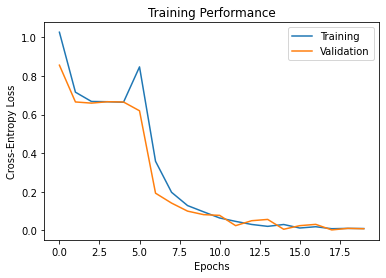

In [10]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('Training Performance')
plt.xlabel('Epochs'); plt.ylabel('Cross-Entropy Loss')
plt.legend(('Training', 'Validation'))

We can test the saved model under a range of SNRs and compare with our achieved decision tree baseline in the previous notebook.

In [11]:
def test_model(model, snr_range, samples_per_frame=128, num_frames=512):
    accs = []

    correct = 0
    total = 0

    model.eval().cpu()

    with torch.no_grad():
        for snr in snr_range:

            bpsk_data = gen_tensor_data('BPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qpsk_data = gen_tensor_data('QPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            psk_data = gen_tensor_data('8-PSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qam_data = gen_tensor_data('16-QAM', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            ask_data = gen_tensor_data('4-ASK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)

            test_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))

            bpsk_labels = torch.zeros(bpsk_data.shape[0])
            qpsk_labels = torch.ones(qpsk_data.shape[0])
            psk_labels = torch.ones(qam_data.shape[0])*2
            qam_labels = torch.ones(qam_data.shape[0])*3
            ask_labels = torch.ones(ask_data.shape[0])*4

            test_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels))

            results = torch.argmax(model(test_data),axis=1)
            accs.append(torch.sum(results == test_labels).float() / test_data.shape[0])
            
    return accs

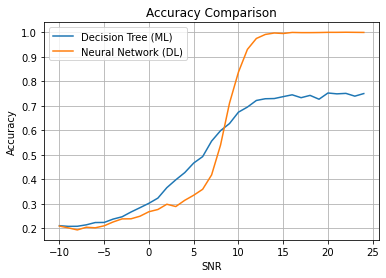

In [13]:
# Load DT baseline
ml_baseline = np.load('baselines/ml_baseline.npy')

# Specify test SNR range
snr_range = np.arange(-10,25)

# Test model
accs_w2 = test_model(model, snr_range, samples_per_frame=1024)

# Plot results
plt.plot(snr_range, ml_baseline)
plt.plot(snr_range, accs_w2)
plt.grid()
plt.title('Accuracy Comparison')
plt.xlabel('SNR'); plt.ylabel('Accuracy')
plt.legend(('Decision Tree (ML)', 'Neural Network (DL)'))
plt.show()

### Train Over A Range of SNRs

Let's see if we can improve performance by increasing the amount of data we are training on.

Epoch 0: Loss 0.6354171442418275
Epoch 1: Loss 0.1870127624990842
Epoch 2: Loss 0.11121225724094654
Epoch 3: Loss 0.05912165755977516
Epoch 4: Loss 0.056182194337502135
Epoch 5: Loss 0.03679030899597406
Epoch 6: Loss 0.035051047616798316
Epoch 7: Loss 0.027680598973223492
Epoch 8: Loss 0.02700794280407618
Epoch 9: Loss 0.02607410112935792
Epoch 10: Loss 0.022713317225927974
Epoch 11: Loss 0.02797176372690625
Epoch 12: Loss 0.025718092325932543
Epoch 13: Loss 0.01596033000211967
Epoch 14: Loss 0.01870269095218191


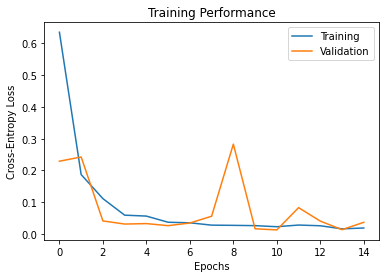

In [14]:
num_epochs = 15

train_snr = np.arange(0,21,2)

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

model = amc_model().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model, losses, val_losses = train_model(model, optimizer, train_loader, val_loader, num_epochs=num_epochs)

plt.plot(losses)
plt.plot(val_losses)
plt.title('Training Performance')
plt.xlabel('Epochs'); plt.ylabel('Cross-Entropy Loss')
plt.legend(('Training', 'Validation'))
plt.show()

## Test results

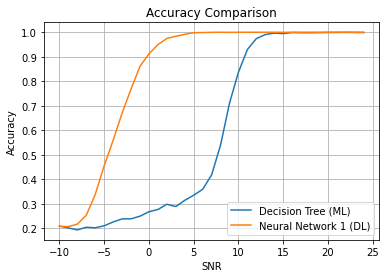

In [15]:
accs = test_model(model, snr_range, samples_per_frame=1024)
# plt.plot(snr_range, ml_baseline)
plt.plot(snr_range, accs_w2)
plt.plot(snr_range, accs)
plt.grid()
plt.title('Accuracy Comparison')
plt.xlabel('SNR'); plt.ylabel('Accuracy')
plt.legend(('Decision Tree (ML)', 'Neural Network 1 (DL)', 'Neural Network 2 (DL)'))
plt.show()

Let's save our best DL result as another baseline for future comparisons.

In [16]:
np.savez('baselines/dl_baseline.npz', accs=accs, snr_range=snr_range)

## Add MTL

In [18]:
class amc_model_mtl(nn.Module):
    def __init__(self):
        super(amc_model_mtl, self).__init__()
            
        # 3 conv layers with a 9 sample wide kernel and padding so that the
        # size of the output remains consistent with the input for each layer
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        # Noise estimator network
        self.noise_estimator = nn.Sequential(
                                    nn.Linear(512,512),
                                    nn.ReLU(),
                                    nn.Linear(512,128),
                                    nn.ReLU(),
                                    nn.Linear(128,64),
                                    nn.Tanh(),
                                    nn.Linear(64,1))
        
        # 128 samples x 16 output filters x 2 channels (I/Q) = 4096
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        
        # Extract features with convolutional layers
        x = self.convolutions(x)
        
        # Flatten so it's compatible with fully connected layers for classification
        x_shared = torch.flatten(x,1)
#         print(x.shape)
        
#         First fully connected layer
        y = F.selu(self.fc1(x_shared))
        
        # Final layer responsible for classifying the 5 modulation schemes
        y = F.selu(self.fc2(y))
        
        y = self.fc3(y)
        
        n = self.noise_estimator(x_shared).squeeze()
        
        return y, n

In [19]:
model_mtl = amc_model_mtl()
model_mtl

amc_model_mtl(
  (convolutions): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): MaxPool1d(kernel_size=2, s

In [20]:
def train_model_mtl(model, optimizer, train_loader, val_loader, num_epochs=5, verbose=True):

    losses, val_losses = [], []
    losses_mod, val_losses_mod = [], []
    losses_snr, val_losses_snr = [], []
    
    loss_class = nn.CrossEntropyLoss()#nn.MSELoss()
    loss_snr = nn.MSELoss()

    # Main training loop
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0

        best_loss = np.inf

        # Loop over entire training loader
        for x_train, y_train, z_train in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat, n_estim = model(x_train)
            loss_1 = loss_class(y_hat, y_train)
            loss_2 = loss_snr(n_estim, z_train)
            
            loss = loss_1 + loss_2
            
            loss.backward()
            optimizer.step()
            
            losses_mod.append(loss_1.item())
            losses_snr.append(loss_2.item())

            # Add to running loss, average later
            running_loss = running_loss + loss.item()

        # Append average loss for this epoch to losses list
        losses.append(running_loss/len(train_loader))

        # Evaluate validation loss

        with torch.no_grad():

            running_val_loss = 0

            for x_val, y_val, z_val in val_loader:

                # evaluate validation loss
                val_outputs, val_snr = model(x_val)
                val_loss1 = loss_class(val_outputs, y_val)
                
                val_loss2 = loss_snr(val_snr, z_val)

                running_val_loss = running_val_loss + val_loss1.item()
                
                val_losses_mod.append(val_loss1.item())
                val_losses_snr.append(val_loss2.item())

            val_losses.append(running_val_loss/len(val_loader))

        if val_losses[-1] < best_loss:
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        if verbose:
            print('Epoch {}: {}'.format(epoch,losses[-1]))

    # Load best model
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr

In [21]:
num_epochs = 15

train_snr = np.arange(0,21,2)

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

model_mtl = amc_model_mtl()
model_mtl.cuda()

optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.001, weight_decay=0.0001)

model_mtl, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr = train_model_mtl(model_mtl, optimizer, train_loader, val_loader, num_epochs=num_epochs, verbose=True)

Epoch 0: 0.6053503513124517
Epoch 1: 0.17813650345302778
Epoch 2: 0.14377786504443396
Epoch 3: 0.12252010815956799
Epoch 4: 0.10353474082393486
Epoch 5: 0.05697903048554012
Epoch 6: 0.0476208609161073
Epoch 7: 0.03934422285356876
Epoch 8: 0.04286948801375481
Epoch 9: 0.029234013126485728
Epoch 10: 0.030675458767390494
Epoch 11: 0.028196995581277983
Epoch 12: 0.020491383559221338
Epoch 13: 0.025655197826497236
Epoch 14: 0.025670263758498055


In [22]:
def test_model_mtl(model, snr_range, num_frames=128, samples_per_frame=1024):
    accs = []
    snr_errs = []

    model.eval().cpu()

    with torch.no_grad():
        for snr in snr_range:

            bpsk_data = gen_tensor_data('BPSK', num_frames=512, samples_per_frame=samples_per_frame, snr=snr)
            qpsk_data = gen_tensor_data('QPSK', num_frames=512, samples_per_frame=samples_per_frame, snr=snr)
            psk_data = gen_tensor_data('8-PSK', num_frames=512, samples_per_frame=samples_per_frame, snr=snr)
            qam_data = gen_tensor_data('16-QAM', num_frames=512, samples_per_frame=samples_per_frame, snr=snr)
            ask_data = gen_tensor_data('4-ASK', num_frames=512, samples_per_frame=samples_per_frame, snr=snr)

            test_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))

            bpsk_labels = torch.zeros(bpsk_data.shape[0])
            qpsk_labels = torch.ones(qpsk_data.shape[0])
            psk_labels = torch.ones(qam_data.shape[0])*2
            qam_labels = torch.ones(qam_data.shape[0])*3
            ask_labels = torch.ones(ask_data.shape[0])*4

            test_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels))

            y_hat, snr_hat = model(test_data)
            
            results = torch.argmax(y_hat,axis=1)
            
            snr_errs.append(F.mse_loss(snr_hat, 1/10**(torch.ones_like(snr_hat)*snr/10)))
            
            accs.append(torch.sum(results == test_labels).float() / test_data.shape[0])
            
    return accs, snr_errs

In [23]:
accs_mtl = test_model_mtl(model_mtl, snr_range)

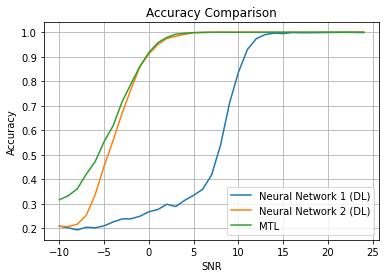

In [24]:
plt.plot(snr_range, accs_w2)
plt.plot(snr_range, accs)
plt.plot(snr_range, accs_mtl[0])
plt.grid()
plt.title('Accuracy Comparison')
plt.xlabel('SNR'); plt.ylabel('Accuracy')
plt.legend(('Neural Network 1 (DL)', 'Neural Network 2 (DL)', 'MTL'))
plt.show()